# Get Forecasts for PR

## Import Modules

In [170]:
import os
import inspect
import time
import math
import json
import logging
import pickle

from energyworx_client.client import EWX
from energyworx_client import storage

import pandas as pd
import numpy as np
from scipy import stats
import pprint
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from IPython.display import display


base = os.getcwd()
namespace = 'na.engie.com'
api = EWX(namespace)
pp = pprint.PrettyPrinter(indent = 1)

## Main Code

### Run all functions listed below first.

In [6]:
write = 'forecasts'

### Search PR_rev in EWX

### Use a .csv of meters

In [10]:
forecasts, tags = grab_ch3("1-HU872K_7")

Empty DataFrame
Columns: [blobKey, createdDatetime, deleted, filename, filesize, lastUpdatedDatetime, marketAdapterId, prefix, readOnly, subdir, tags, uri, meter]
Index: []
found 0 meters:

error
error
error
error
error
error


ValueError: need more than 0 values to unpack

In [115]:
#meters = storage.read_csv('1-J6BBZM.csv')
meters = pd.DataFrame(['PJM_DQE_2426920626', 'PJM_DQE_8152222837 '])
meters.columns = ['meter']

PR_data = pd.DataFrame()
cap_tags = pd.DataFrame()

print 'downloading forecasts for {} meters:'.format(len(meters.meter))
for i, m in enumerate(meters.meter):
    
    PR_data, cap_tags = meter_search(m, PR_data, cap_tags)
    n = len(meters.meter)
    if i % 5 == 0 and i > 0:
        print('downloaded forecasts for {} of {} meters.'.format(i, n))

PR_data.fillna(value = 0, axis = 1, inplace = True)    
PR_data.head()
cap_tags.head()

downloading forecasts for 2 meters:


KeyError: 0

Save PR_data as a pickle file

In [17]:
pickled_df = pickle.dumps(PR_data)
storage.to_file('PR_data_ALAKAI_TECH.pkl', pickled_df)

In [32]:
meter_list = PR_data.columns.to_series()
meter_list

NEPOOL_BECO_26815890079    NEPOOL_BECO_26815890079
NEPOOL_BECO_28487090046    NEPOOL_BECO_28487090046
dtype: object

In [37]:
a = pd.DataFrame(PR_data[meter_list[0]])
b = pd.DataFrame(PR_data[meter_list[1]])

print(a.head())
print(a.tail())

#a.set_index(pd.to_Datetime(a.index))
#b.set_index(pd.to_Datetime(b.index))
a.columns = ['v']
b.columns = ['v']

                     NEPOOL_BECO_26815890079
t                                           
2019-01-01 00:00:00                 2.031098
2019-01-01 01:00:00                 1.976276
2019-01-01 02:00:00                 1.997670
2019-01-01 03:00:00                 1.969590
2019-01-01 04:00:00                 2.004088
                     NEPOOL_BECO_26815890079
t                                           
2030-02-28 19:00:00                 3.097024
2030-02-28 20:00:00                 2.892884
2030-02-28 21:00:00                 2.584237
2030-02-28 22:00:00                 2.376849
2030-02-28 23:00:00                 2.269364


In [51]:
def load_inc(data):
    data['yr'] = [date.year for date in data.index]
    data['mon'] = [date.month for date in data.index]
    mon_mean = data.groupby([data['yr'], data['mon']])
    mu = mon_mean.mean()
    mu.columns = ['mu']
    sd = mon_mean.std()
    sd.columns = ['sd']
    
    output = pd.merge(data, mu, how = 'left', right_index = True, left_on = ['yr', 'mon'])
    output = pd.merge(output, sd, how = 'left', right_index = True, left_on = ['yr', 'mon'])
    return output

a2 = load_inc(a)
b2 = load_inc(b)

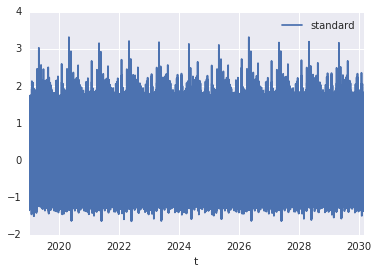

In [102]:
a2['standard'] = [(y - u)/s for y, u, s in zip(a2.v, a2.mu, a2.sd)]
b2['standard'] = [(y - u)/s for y, u, s in zip(b2.v, b2.mu, b2.sd)]

a2.plot(y = 'standard')

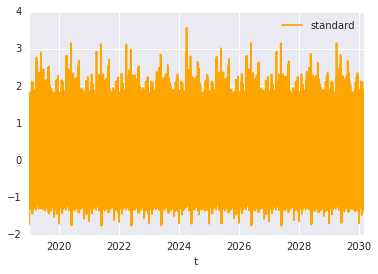

In [103]:
b2.plot(y = 'standard', color = 'orange')

In [99]:
def load_inc_mult(data):
    mult = []
    adj = []
    data['sgn'] = np.sign(data.standard)
    temp = pd.DataFrame(data[data.yr == 2019])
    n = len(temp)


    ### first yr increase
    for i, x in enumerate(temp.standard):
        factor = 1 + i/n
    
        mult.append(factor)
        if temp.sgn[i] > 0:
            adj.append(temp.standard[i]*factor)
        else:
            adj.append(temp.standard[i])

    print('first yr adj')
    ### second yr
    temp2 = pd.DataFrame(data[data.yr == 2020])
    m = len(temp2)

    for i, x in enumerate(temp2.standard):
        factor = 1 + 2*i/m
    
        mult.append(factor)
        if temp2.sgn[i] > 0:
            adj.append(temp2.standard[i]*factor)
        else:
            adj.append(temp2.standard[i])

    print('second yr adj')
    ### third yr
    temp3 = pd.DataFrame(data[data.yr == 2021])
    p = len(temp3)

    for i, x in enumerate(temp3.standard):
        factor = 1 + 3*i/p
    
        mult.append(factor)
        if temp3.sgn[i] > 0:
            adj.append(temp3.standard[i]*factor)
        else:
            adj.append(temp3.standard[i])

    print('third yr adj')

    #### rest yrs adj
    final_factor = max(mult)
    final_yr = [y > 2021 for y in data.yr]

    temp4 = pd.DataFrame(data[final_yr])
    print('subset')
    for i, x in enumerate(temp4.standard):
        if temp4.sgn[i] > 0:
            adj.append(final_factor*temp4.standard[i])
        else:
            adj.append(temp4.standard[i])


    print('final adj len {}'.format(len(adj)))
    print('data len {}'.format(len(data.standard)))
    data['adj'] = adj
    return(data)

In [104]:
a3 = load_inc_mult(a2)
b3 = load_inc_mult(b2)

first yr adj
second yr adj
third yr adj
subset
final adj len 97848
data len 97848
first yr adj
second yr adj
third yr adj
subset
final adj len 97848
data len 97848


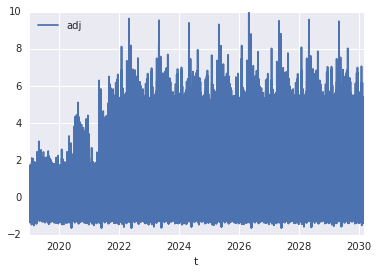

In [105]:
a3.plot(y = 'adj')

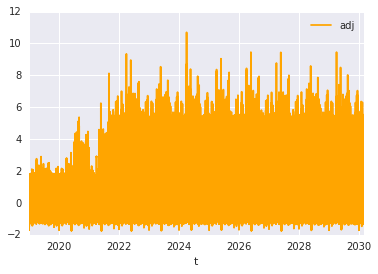

In [106]:
b3.plot(y = 'adj', color = 'orange')

In [108]:
a2['adj_v'] = [y*s + u for y, u, s in zip(a2.adj, a2.mu, a2.sd)]
b2['adj_v'] = [y*s + u for y, u, s in zip(b2.adj, b2.mu, b2.sd)]

In [111]:
a_name = ''.join([meter_list[0], '_LOAD_ADJ.csv'])
b_name = ''.join([meter_list[1], '_LOAD_ADJ.csv'])

In [112]:
storage.to_csv(a2, a_name)
storage.to_csv(b2, b_name)

In [ ]:
storage.to_csv(PR_data, 'ALAKAI_TECH_CH3.csv')

## Offer Summary

PR has total usage of 226860.019 MWh.
PR has an estimated tag total of 2619.121 kWh.
PR has CP peak sum of 3255.408 kWh.
PR has peak (sum(act_peak)) of 7086.107 kWh, and 30 meters.
(13, 4, 3)


,Annual_Use_MWh,Act_Peak,CP,Tag,Act_Tag_Diff,Cap_Tag_Diff
meter,,,,,,
NEPOOL_CLP_51091936070_112761006,16.196,0.695,0.530,0.811,-14.303329,-34.648582
NEPOOL_CLP_51091936070_767851001,16.138,0.861,0.327,0.500,72.200000,-34.600000
NEPOOL_CLP_51099277014_119181007,1393.961,63.023,18.501,31.289,101.422225,-40.870593
NEPOOL_CLP_51101743003_597232004,6948.689,2149.476,27.002,86.552,2383.450411,-68.802570
NEPOOL_CLP_51119377000_524181004,908.769,43.014,11.879,20.091,114.095864,-40.874023
NEPOOL_CLP_51180777047_913281005,897.602,41.800,11.925,20.168,107.259024,-40.871678
NEPOOL_CLP_51200017051_729812001,3471.929,149.731,85.928,130.795,14.477618,-34.303299
NEPOOL_CLP_51220643092_329332003,2.435,0.684,0.015,0.046,1386.956522,-67.391304
NEPOOL_CLP_51282843036_653432007,112.761,26.365,0.546,1.750,1406.571429,-68.800000


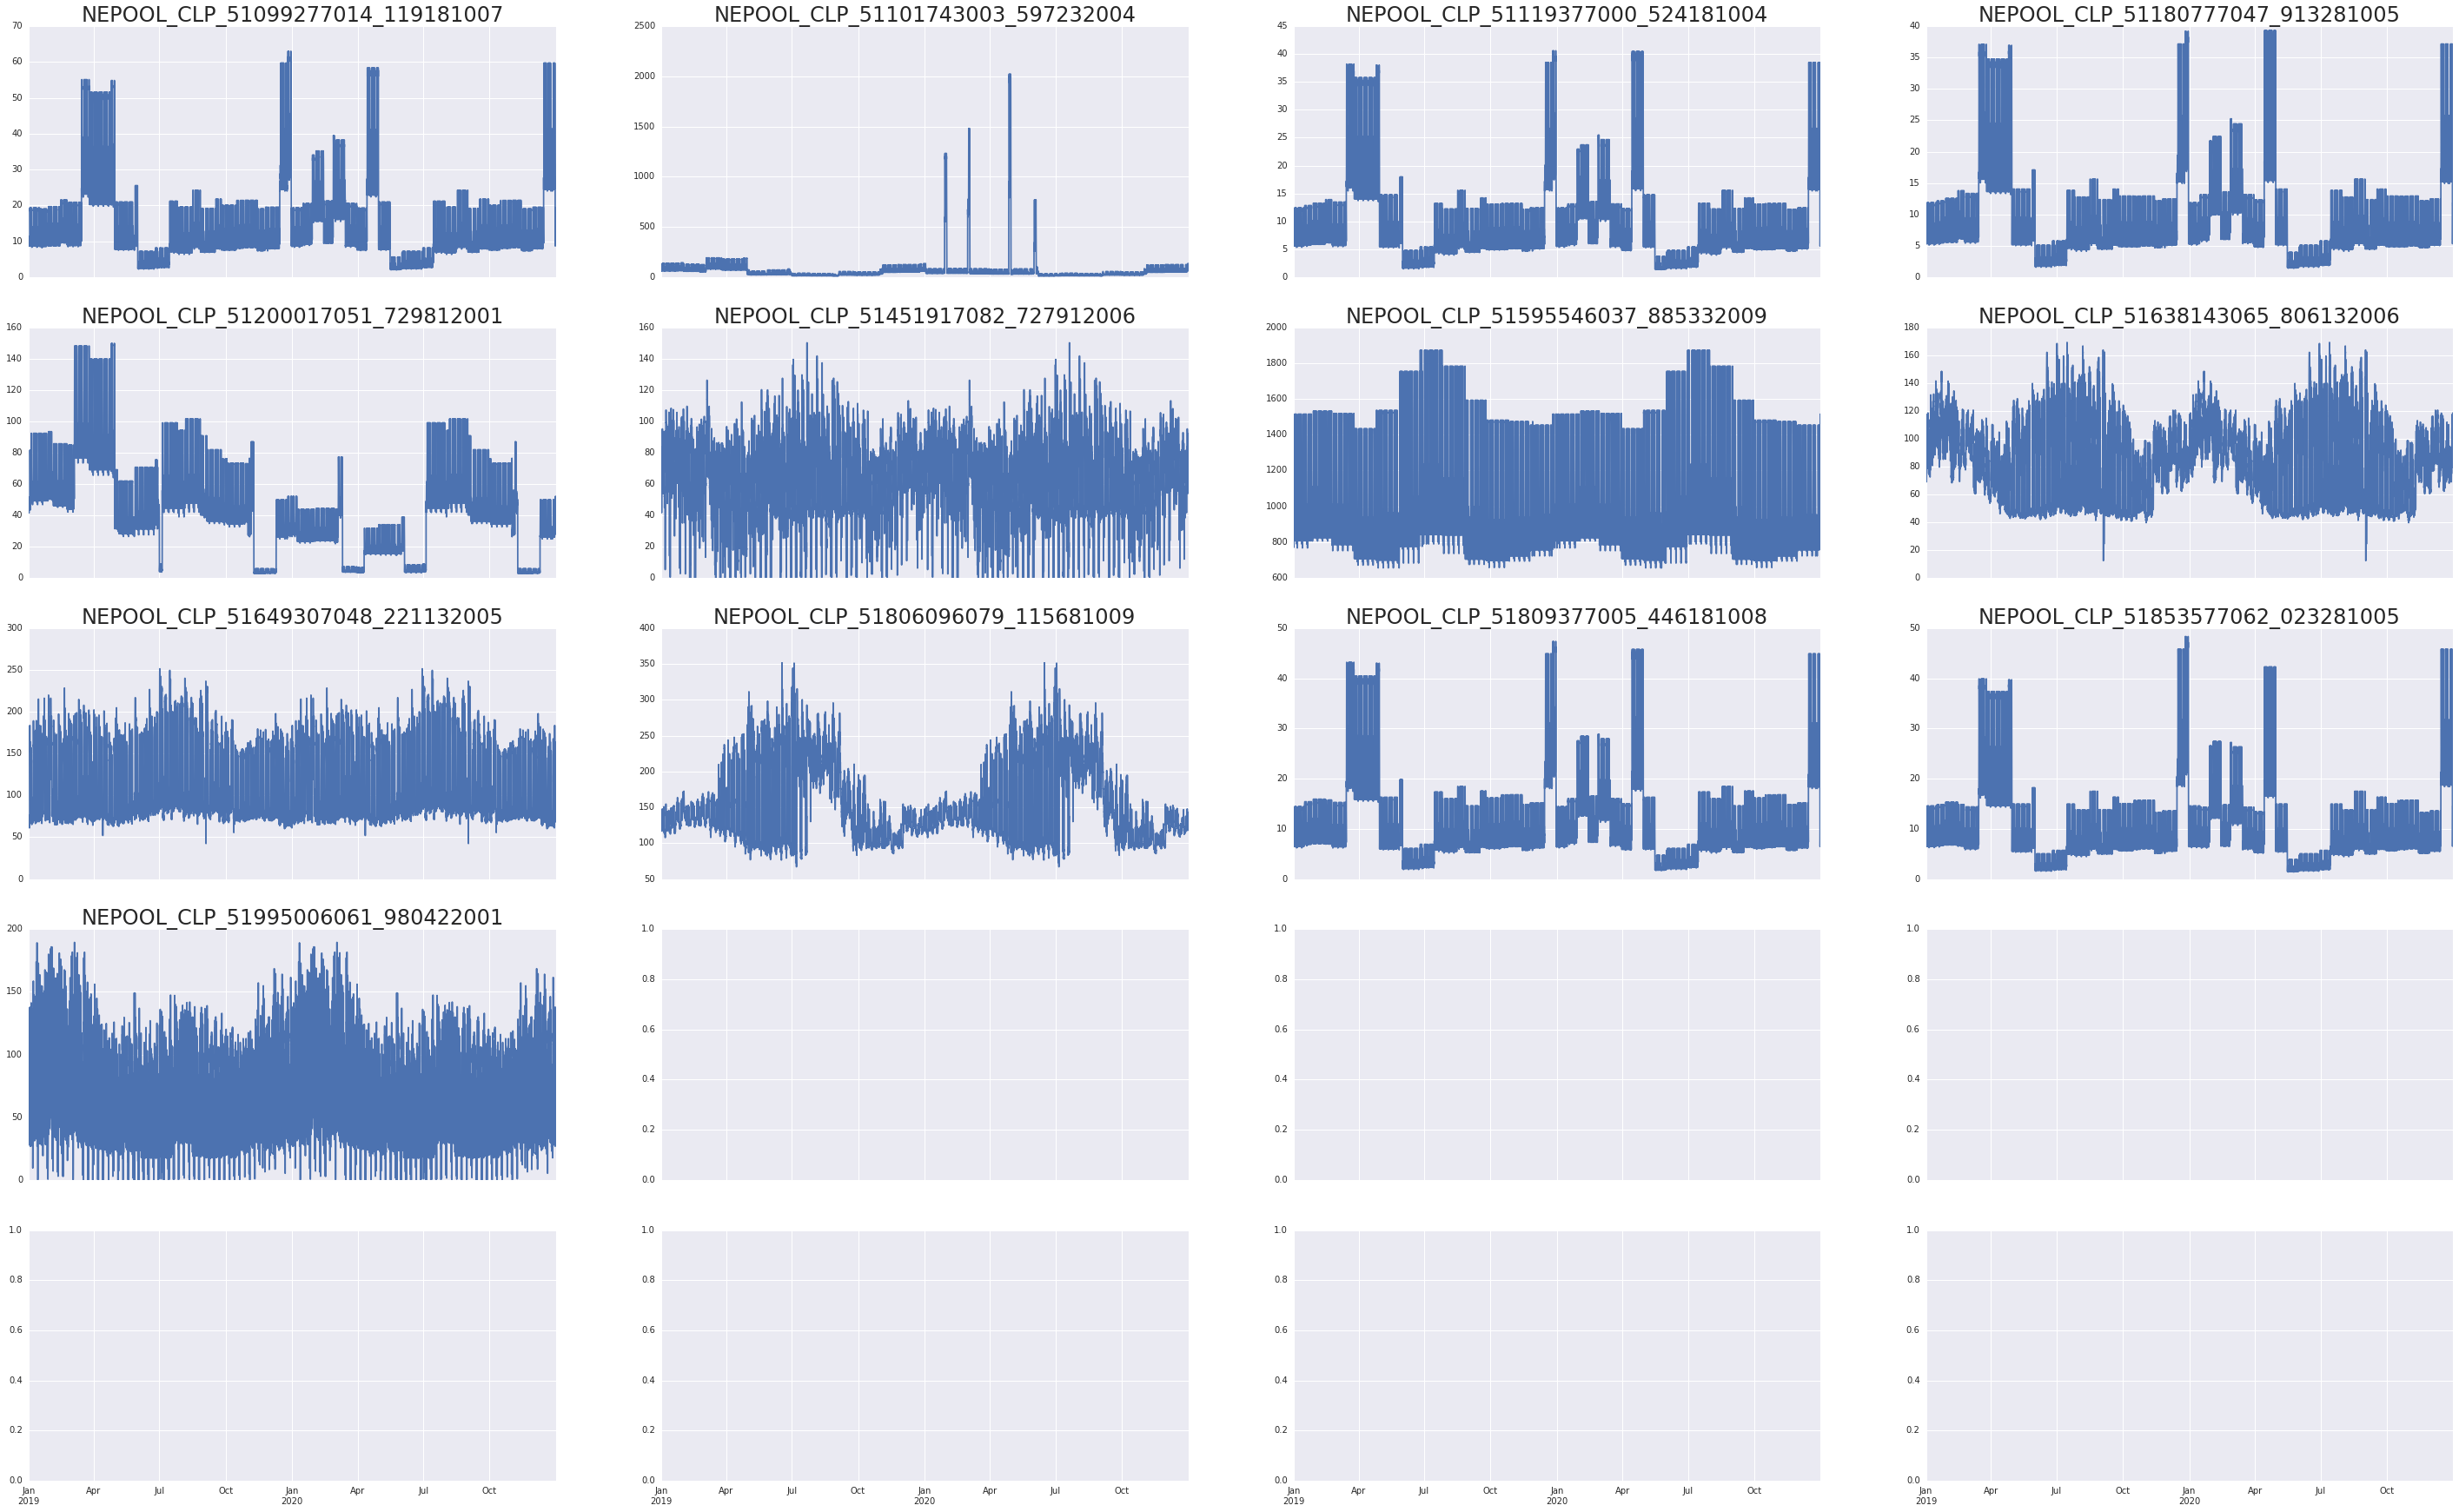

In [27]:
offer_summary(PR_data, cap_tags, 15, 10)

## ------------------------------------------------------

## json_parse_csv Function

Helper function to convert .json to .csv

In [171]:
def json_parse_csv(raw, name):
    
    #print "loading json..."
    data = json.loads(raw) #raw json file
    acct = data['account'] #get account data
    ch3 = acct['timeseriesdataidr'] #dictionary of acct attributes
    n = len(ch3)
        
    reads = ch3[0]['reads']
    
    caps = acct['captag']

    caps_df = pd.DataFrame(caps)
    caps_df['start'] = pd.to_datetime(caps_df['start'])
    caps_df['stop'] = pd.to_datetime(caps_df['stop'])
    caps_df.v = [float(val) for val in caps_df.v]
    rows = caps_df.shape[0]
    
    master_df = pd.DataFrame.from_dict(reads)
        
    #print 'found {} reads, creating dataset.'.format(n)
        
    filename = name.split('_')
    filename = '_'.join(filename)
    filename = filename.replace('.json', '.csv')
    meter = filename.split('.')[0]
    
    caps_df['meter'] = [meter]*rows
    
    #display(caps_df)
        
    for i in range(1,n):
        reads = ch3[i]['reads']
        temp = pd.DataFrame.from_dict(reads)
            
        tempname = "_".join([filename.split('.')[0], 'year', str(i), '.csv'])
        full_temp = os.path.join(write, tempname)
        #print 'writing {}'.format(tempname)
            
        storage.to_csv(temp, full_temp)
        master_df = pd.concat([master_df, temp]).reset_index(drop = True)
        
    master_df.v = [float(val) for val in master_df.v]
    master_df.t = pd.DatetimeIndex(pd.to_datetime(master_df.t))
    master_df.set_index("t", inplace = True, drop = True)
    #print(master_df.head())
    #print(master_df.tail())
        
    
    #print "saving to dataframe..."
    
    #print 'writing file to csv' 
    master_file = os.path.join(write, filename)
    storage.to_csv(master_df, master_file)
    return(master_df, caps_df)

## grab_ch3 Function

Function to grab all EWX forecasts for every meter in a given **PR_rev**

In [4]:
def json_parse_csv(raw, name):
    
    #print "loading json..."
    data = json.loads(raw) #raw json file
    acct = data['account'] #get account data
    ch3 = acct['timeseriesdataidr'] #dictionary of acct attributes
    n = len(ch3)
        
    reads = ch3[0]['reads']
    
    caps = acct['captag']

    caps_df = pd.DataFrame(caps)
    caps_df['start'] = pd.to_datetime(caps_df['start'])
    caps_df['stop'] = pd.to_datetime(caps_df['stop'])
    caps_df.v = [float(val) for val in caps_df.v]
    rows = caps_df.shape[0]
    
    master_df = pd.DataFrame.from_dict(reads)
        
    #print 'found {} reads, creating dataset.'.format(n)
        
    filename = name.split('_')
    filename = '_'.join(filename)
    filename = filename.replace('.json', '.csv')
    meter = filename.split('.')[0]
    
    caps_df['meter'] = [meter]*rows
    
    #display(caps_df)
        
    for i in range(1,n):
        reads = ch3[i]['reads']
        temp = pd.DataFrame.from_dict(reads)
            
        tempname = "_".join([filename.split('.')[0], 'year', str(i), '.csv'])
        full_temp = os.path.join(write, tempname)
        #print 'writing {}'.format(tempname)
            
        storage.to_csv(temp, full_temp)
        master_df = pd.concat([master_df, temp]).reset_index(drop = True)
        
    master_df.v = [float(val) for val in master_df.v]
    master_df.t = pd.DatetimeIndex(pd.to_datetime(master_df.t))
    master_df.set_index("t", inplace = True, drop = True)
    #print(master_df.head())
    #print(master_df.tail())
        
    
    #print "saving to dataframe..."
    
    #print 'writing file to csv' 
    master_file = os.path.join(write, filename)
    storage.to_csv(master_df, master_file)
    return(master_df, caps_df)

def grab_ch3(meter):
    
    #iterate thru meters in PR (in EWX)
    PR_data = pd.DataFrame()
    cap_tags = pd.DataFrame()
    
    try:
        file_result = api.search_files(filename = meter)['items']

        #pp.pprint(file_result)
        file_df = pd.DataFrame(file_result)
        file_sub = file_df[['filename', 'tags', 'blobKey', 'createdDatetime']]
        response = file_sub[[file_sub.createdDatetime == max(file_sub.createdDatetime)]]
        this_file = "_".join(response.filename[0].split('_')[1:])
        print(response)
            
        if not response.empty:
            
            print 'grabbing ch 3 for {}...'.format(this_file)

            json_file = api.download_file(blob_key = response.blobKey[0])
        
            print '...'
            ch3_output, tags = json_parse_csv(json_file, this_file)
            cap_tags = pd.concat([cap_tags, tags], axis = 0)
            
                ch3_output.columns = [uniq_meter[index]]
                print 'downloaded, merging w/ PR dataframe...'
                PR_data = pd.concat([PR_data, ch3_output], axis = 1)
                display(PR_data.head())
                print '...'
                display(PR_data.tail())
                
            
    except:
        print 'error, meter {}.'.format(meter)

    cap_tags.drop_duplicates(keep = 'first', inplace = True)
    return(PR_data, cap_tags)

def meter_search(meter, PR_data, cap_tags):
    
    file_result = api.search_files(tags = meter)['items']
    
    file_df = pd.DataFrame(file_result)
    file_sub = file_df[['filename', 'tags', 'blobKey', 'createdDatetime']]
    file_sub = file_sub[['response' in tag for tag in file_sub.tags]]
    response = file_sub[[a == max(file_sub.createdDatetime) for a in file_sub.createdDatetime]]
    this_file = "_".join(response.filename[0].split('_')[1:])
    metername = this_file.split('.')[0]
            
    if not response.empty:
            
        #print 'grabbing ch 3 for {}...'.format(this_file)

        json_file = api.download_file(blob_key = response.blobKey[0])
        
        #print '...'
        ch3_output, tags = json_parse_csv(json_file, this_file)
        cap_tags = pd.concat([cap_tags, tags], axis = 0)
            
        ch3_output.columns = [metername]
        #print 'downloaded, merging w/ PR dataframe...'
        PR_data = pd.concat([PR_data, ch3_output], axis = 1)
        #print '...'
        
    else:
        print 'forcast not found for {}.'.format(meter)
        
    return(PR_data, cap_tags)

## offer_summary Function

Function to run some offer summary statistics

In [12]:
def offer_summary(idr, caps, min_cp, min_diff):
    tag_date = dt.datetime.strptime('2019-08-29 17:00:00', '%Y-%m-%d %H:%M:%S')

    act_max = pd.DataFrame(idr.apply(max, axis = 0))
    cp_max = idr.loc[idr.index == tag_date].reset_index(drop = True).T

    start_yrs = [yr.year == 2019 for yr in caps.start]
    cap = caps[['meter', 'v']].loc[start_yrs].reset_index(drop = True)
    cap = cap.set_index('meter')

    annual_use = pd.DataFrame(.001*idr.apply(sum, axis = 0), columns = ['Annual_Use'])

    peak_data = pd.concat([annual_use, act_max, cp_max, cap], axis = 1).round(decimals = 3)
    peak_data.columns = ['Annual_Use_MWh', 'Act_Peak', 'CP', 'Tag']
    peak_data['Act_Tag_Diff'] = (peak_data.Act_Peak - peak_data.Tag)/peak_data.Tag*100
    peak_data['Cap_Tag_Diff'] = (peak_data.CP - peak_data.Tag)/peak_data.Tag*100

    tot_vol = round(sum(peak_data.Annual_Use_MWh), 4)
    tot_peak = round(sum(peak_data.Act_Peak), 4)
    tot_CP = round(sum(peak_data.CP), 4)
    tag_tot = round(sum(peak_data.Tag), 4)

    print 'PR has total usage of {} MWh.'.format(tot_vol)
    print 'PR has an estimated tag total of {} kWh.'.format(tag_tot)
    print 'PR has CP peak sum of {} kWh.'.format(tot_CP)
    print 'PR has peak (sum(act_peak)) of {} kWh, and {} meters.'.format(tot_peak, len(peak_data.index))
    
    high = [t > min_cp for t in peak_data.Tag]
    big = [abs(d) > min_diff for d in peak_data.Act_Tag_Diff]
    both = [a and b for a, b in zip(high, big)]

    problems = peak_data[both]
    
    prob_meters = problems.index.to_series().values
    n = len(prob_meters)
    a = int(math.ceil(math.sqrt(n)))
    b = int(n // a)
    print(n, a, b)

    if (a*b < n):
        if (a < b):
            a += 1
        else:
            b += 1
        
    if n > 1:
        fig, axes = plt.subplots(nrows=a, ncols=b, sharex=True, sharey=False, figsize=(50,30))
        axes_list = [item for sublist in axes for item in sublist]
        

        for m in prob_meters:
            ax = axes_list.pop(0);
            ax.set_title(m, fontsize = 24);
            plt.rc('axes', labelsize = 'large')
            meter_df = PR_data.loc[:,m]
            rec_yr = [a < 2021 for a in meter_df.index.year]
            meter_df[rec_yr].plot(y = m, ax = ax);
            
    else:
        m = problems.index[0]
        fig, axes = plt.subplots(nrows=a, ncols=b, sharex=True, sharey=False, figsize=(50,30))
        ax.set_title(m, fontsize = 24);
        plt.rc('axes', labelsize = 'large')
        meter_df = PR_data.loc[:,m]
        rec_yr = [a < 2021 for a in meter_df.index.year]
        meter_df[rec_yr].plot(y = m, ax = ax);
    
    return(peak_data)

In [13]:
def meter_search(meter, PR_data, cap_tags):
    
    file_result = api.search_files(tags = meter)['items']
    
    file_df = pd.DataFrame(file_result)
    file_sub = file_df[['filename', 'tags', 'blobKey', 'createdDatetime']]
    file_sub = file_sub[['response' in tag for tag in file_sub.tags]]
    response = file_sub[[a == max(file_sub.createdDatetime) for a in file_sub.createdDatetime]]
    this_file = "_".join(response.filename[0].split('_')[1:])
    metername = this_file.split('.')[0]
            
    if not response.empty:
            
        #print 'grabbing ch 3 for {}...'.format(this_file)

        json_file = api.download_file(blob_key = response.blobKey[0])
        
        #print '...'
        ch3_output, tags = json_parse_csv(json_file, this_file)
        cap_tags = pd.concat([cap_tags, tags], axis = 0)
            
        ch3_output.columns = [metername]
        #print 'downloaded, merging w/ PR dataframe...'
        PR_data = pd.concat([PR_data, ch3_output], axis = 1)
        #print '...'
        
    else:
        print 'forcast not found for {}.'.format(meter)
        
    return(PR_data, cap_tags)